In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_1_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_nat_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4339345, 828)
(4339345, 8)
validation
(669326, 828)
(669326, 8)
test
(492897, 828)
(492897, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4486024 (17.11 MB)


Trainable params: 4486024 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

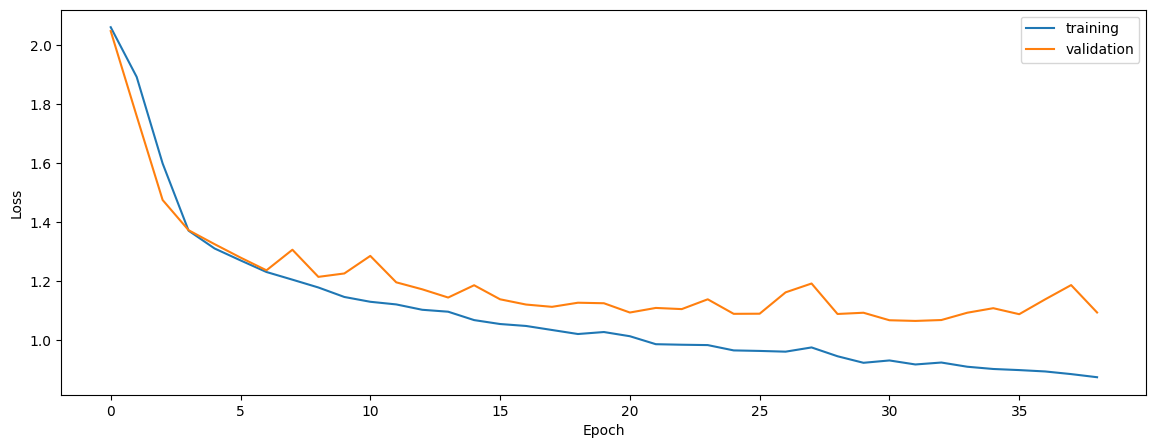

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_nat_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1160792, 828)
(1160792, 1)
validation
(184723, 828)
(184723, 1)
test
(137164, 828)
(137164, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_6 (Dense)             (None, 2048)              1697792   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/12 [=>............................] - ETA: 2:06 - loss: 0.2265 - STD: 1.1268e-04 - MAE: 0.4318

 2/12 [====>.........................] - ETA: 4s - loss: 0.2374 - STD: 7.8138e-05 - MAE: 0.4585  

 3/12 [======>.......................] - ETA: 3s - loss: 0.2333 - STD: 8.9002e-05 - MAE: 0.4606

 4/12 [=========>....................] - ETA: 3s - loss: 0.2303 - STD: 1.1388e-04 - MAE: 0.4551

 5/12 [===========>..................] - ETA: 3s - loss: 0.2303 - STD: 1.3976e-04 - MAE: 0.4500

 6/12 [==============>...............] - ETA: 2s - loss: 0.2301 - STD: 1.6616e-04 - MAE: 0.4465

 7/12 [================>.............] - ETA: 2s - loss: 0.2290 - STD: 1.9183e-04 - MAE: 0.4448

 8/12 [===================>..........] - ETA: 1s - loss: 0.2278 - STD: 2.1486e-04 - MAE: 0.4449

 9/12 [=====================>........] - ETA: 1s - loss: 0.2269 - STD: 2.3399e-04 - MAE: 0.4461

10/12 [========================>.....] - ETA: 0s - loss: 0.2266 - STD: 2.4962e-04 - MAE: 0.4477

11/12 [==========================>...] - ETA: 0s - loss: 0.2263 - STD: 2.6275e-04 - MAE: 0.4490

12/12 [==============================] - ETA: 0s - loss: 0.2261 - STD: 2.7414e-04 - MAE: 0.4499

12/12 [==============================] - 27s 1s/step - loss: 0.2261 - STD: 2.7414e-04 - MAE: 0.4499 - val_loss: 0.2198 - val_STD: 3.9381e-04 - val_MAE: 0.4541


Epoch 2/10000


 1/12 [=>............................] - ETA: 5s - loss: 0.2196 - STD: 4.0470e-04 - MAE: 0.4531

 2/12 [====>.........................] - ETA: 6s - loss: 0.2189 - STD: 4.0477e-04 - MAE: 0.4494

 3/12 [======>.......................] - ETA: 5s - loss: 0.2193 - STD: 4.0402e-04 - MAE: 0.4465

 4/12 [=========>....................] - ETA: 4s - loss: 0.2199 - STD: 4.0450e-04 - MAE: 0.4444

 5/12 [===========>..................] - ETA: 3s - loss: 0.2202 - STD: 4.0733e-04 - MAE: 0.4430

 6/12 [==============>...............] - ETA: 2s - loss: 0.2202 - STD: 4.1247e-04 - MAE: 0.4422

 7/12 [================>.............] - ETA: 2s - loss: 0.2201 - STD: 4.1997e-04 - MAE: 0.4422

 8/12 [===================>..........] - ETA: 1s - loss: 0.2199 - STD: 4.2970e-04 - MAE: 0.4428

 9/12 [=====================>........] - ETA: 1s - loss: 0.2198 - STD: 4.4123e-04 - MAE: 0.4436

10/12 [========================>.....] - ETA: 0s - loss: 0.2199 - STD: 4.5350e-04 - MAE: 0.4447

11/12 [==========================>...] - ETA: 0s - loss: 0.2199 - STD: 4.6673e-04 - MAE: 0.4456

12/12 [==============================] - ETA: 0s - loss: 0.2199 - STD: 4.8073e-04 - MAE: 0.4464

12/12 [==============================] - 6s 540ms/step - loss: 0.2199 - STD: 4.8073e-04 - MAE: 0.4464 - val_loss: 0.2197 - val_STD: 6.5635e-04 - val_MAE: 0.4539


Epoch 3/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.2195 - STD: 6.7539e-04 - MAE: 0.4529

 2/12 [====>.........................] - ETA: 4s - loss: 0.2195 - STD: 6.9441e-04 - MAE: 0.4517 

 3/12 [======>.......................] - ETA: 3s - loss: 0.2192 - STD: 7.1595e-04 - MAE: 0.4501

 4/12 [=========>....................] - ETA: 3s - loss: 0.2192 - STD: 7.3932e-04 - MAE: 0.4487

 5/12 [===========>..................] - ETA: 2s - loss: 0.2193 - STD: 7.6579e-04 - MAE: 0.4476

 6/12 [==============>...............] - ETA: 2s - loss: 0.2193 - STD: 7.9495e-04 - MAE: 0.4467

 7/12 [================>.............] - ETA: 1s - loss: 0.2193 - STD: 8.2911e-04 - MAE: 0.4463

 8/12 [===================>..........] - ETA: 1s - loss: 0.2192 - STD: 8.6669e-04 - MAE: 0.4461

 9/12 [=====================>........] - ETA: 1s - loss: 0.2191 - STD: 9.1039e-04 - MAE: 0.4462

10/12 [========================>.....] - ETA: 0s - loss: 0.2191 - STD: 9.5871e-04 - MAE: 0.4465

11/12 [==========================>...] - ETA: 0s - loss: 0.2191 - STD: 0.0010 - MAE: 0.4469    

12/12 [==============================] - ETA: 0s - loss: 0.2190 - STD: 0.0011 - MAE: 0.4471

12/12 [==============================] - 7s 560ms/step - loss: 0.2190 - STD: 0.0011 - MAE: 0.4471 - val_loss: 0.2185 - val_STD: 0.0019 - val_MAE: 0.4507


Epoch 4/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.2192 - STD: 0.0019 - MAE: 0.4506

 2/12 [====>.........................] - ETA: 5s - loss: 0.2188 - STD: 0.0020 - MAE: 0.4496 

 3/12 [======>.......................] - ETA: 3s - loss: 0.2187 - STD: 0.0021 - MAE: 0.4488

 4/12 [=========>....................] - ETA: 3s - loss: 0.2186 - STD: 0.0023 - MAE: 0.4481

 5/12 [===========>..................] - ETA: 3s - loss: 0.2185 - STD: 0.0024 - MAE: 0.4476

 6/12 [==============>...............] - ETA: 2s - loss: 0.2185 - STD: 0.0026 - MAE: 0.4471

 7/12 [================>.............] - ETA: 2s - loss: 0.2185 - STD: 0.0028 - MAE: 0.4467

 8/12 [===================>..........] - ETA: 1s - loss: 0.2184 - STD: 0.0030 - MAE: 0.4465

 9/12 [=====================>........] - ETA: 1s - loss: 0.2183 - STD: 0.0033 - MAE: 0.4465

10/12 [========================>.....] - ETA: 0s - loss: 0.2182 - STD: 0.0036 - MAE: 0.4465

11/12 [==========================>...] - ETA: 0s - loss: 0.2181 - STD: 0.0039 - MAE: 0.4465

12/12 [==============================] - ETA: 0s - loss: 0.2180 - STD: 0.0043 - MAE: 0.4465

12/12 [==============================] - 7s 569ms/step - loss: 0.2180 - STD: 0.0043 - MAE: 0.4465 - val_loss: 0.2158 - val_STD: 0.0100 - val_MAE: 0.4457


Epoch 5/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.2164 - STD: 0.0102 - MAE: 0.4452

 2/12 [====>.........................] - ETA: 4s - loss: 0.2165 - STD: 0.0111 - MAE: 0.4449

 3/12 [======>.......................] - ETA: 3s - loss: 0.2162 - STD: 0.0122 - MAE: 0.4442

 4/12 [=========>....................] - ETA: 3s - loss: 0.2158 - STD: 0.0134 - MAE: 0.4435

 5/12 [===========>..................] - ETA: 3s - loss: 0.2155 - STD: 0.0149 - MAE: 0.4428

 6/12 [==============>...............] - ETA: 2s - loss: 0.2150 - STD: 0.0166 - MAE: 0.4421

 7/12 [================>.............] - ETA: 2s - loss: 0.2145 - STD: 0.0186 - MAE: 0.4414

 8/12 [===================>..........] - ETA: 1s - loss: 0.2140 - STD: 0.0209 - MAE: 0.4407

 9/12 [=====================>........] - ETA: 1s - loss: 0.2137 - STD: 0.0235 - MAE: 0.4398

10/12 [========================>.....] - ETA: 0s - loss: 0.2130 - STD: 0.0264 - MAE: 0.4389

11/12 [==========================>...] - ETA: 0s - loss: 0.2123 - STD: 0.0296 - MAE: 0.4377

12/12 [==============================] - ETA: 0s - loss: 0.2116 - STD: 0.0330 - MAE: 0.4364

12/12 [==============================] - 7s 569ms/step - loss: 0.2116 - STD: 0.0330 - MAE: 0.4364 - val_loss: 0.1989 - val_STD: 0.0815 - val_MAE: 0.4169


Epoch 6/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.2025 - STD: 0.0816 - MAE: 0.4192

 2/12 [====>.........................] - ETA: 3s - loss: 0.2019 - STD: 0.0869 - MAE: 0.4176 

 3/12 [======>.......................] - ETA: 3s - loss: 0.2008 - STD: 0.0922 - MAE: 0.4158

 4/12 [=========>....................] - ETA: 3s - loss: 0.2000 - STD: 0.0970 - MAE: 0.4141

 5/12 [===========>..................] - ETA: 3s - loss: 0.1993 - STD: 0.1010 - MAE: 0.4125

 6/12 [==============>...............] - ETA: 2s - loss: 0.1988 - STD: 0.1045 - MAE: 0.4111

 7/12 [================>.............] - ETA: 2s - loss: 0.1981 - STD: 0.1081 - MAE: 0.4097

 8/12 [===================>..........] - ETA: 1s - loss: 0.1977 - STD: 0.1119 - MAE: 0.4087

 9/12 [=====================>........] - ETA: 1s - loss: 0.1974 - STD: 0.1152 - MAE: 0.4077

10/12 [========================>.....] - ETA: 0s - loss: 0.1970 - STD: 0.1178 - MAE: 0.4067

11/12 [==========================>...] - ETA: 0s - loss: 0.1967 - STD: 0.1202 - MAE: 0.4059

12/12 [==============================] - ETA: 0s - loss: 0.1964 - STD: 0.1226 - MAE: 0.4050

12/12 [==============================] - 7s 544ms/step - loss: 0.1964 - STD: 0.1226 - MAE: 0.4050 - val_loss: 0.1907 - val_STD: 0.1530 - val_MAE: 0.3935


Epoch 7/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1928 - STD: 0.1549 - MAE: 0.3943

 2/12 [====>.........................] - ETA: 2s - loss: 0.1927 - STD: 0.1561 - MAE: 0.3938

 3/12 [======>.......................] - ETA: 2s - loss: 0.1925 - STD: 0.1549 - MAE: 0.3935

 4/12 [=========>....................] - ETA: 2s - loss: 0.1925 - STD: 0.1553 - MAE: 0.3932

 5/12 [===========>..................] - ETA: 2s - loss: 0.1925 - STD: 0.1560 - MAE: 0.3930

 6/12 [==============>...............] - ETA: 2s - loss: 0.1924 - STD: 0.1569 - MAE: 0.3926

 7/12 [================>.............] - ETA: 1s - loss: 0.1921 - STD: 0.1568 - MAE: 0.3924

 8/12 [===================>..........] - ETA: 1s - loss: 0.1920 - STD: 0.1569 - MAE: 0.3922

 9/12 [=====================>........] - ETA: 1s - loss: 0.1919 - STD: 0.1574 - MAE: 0.3921

10/12 [========================>.....] - ETA: 0s - loss: 0.1919 - STD: 0.1580 - MAE: 0.3918

11/12 [==========================>...] - ETA: 0s - loss: 0.1919 - STD: 0.1581 - MAE: 0.3917

12/12 [==============================] - ETA: 0s - loss: 0.1918 - STD: 0.1582 - MAE: 0.3915

12/12 [==============================] - 7s 551ms/step - loss: 0.1918 - STD: 0.1582 - MAE: 0.3915 - val_loss: 0.1899 - val_STD: 0.1568 - val_MAE: 0.3912


Epoch 8/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1903 - STD: 0.1608 - MAE: 0.3893

 2/12 [====>.........................] - ETA: 4s - loss: 0.1904 - STD: 0.1589 - MAE: 0.3898 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1903 - STD: 0.1587 - MAE: 0.3898

 4/12 [=========>....................] - ETA: 3s - loss: 0.1904 - STD: 0.1601 - MAE: 0.3895

 5/12 [===========>..................] - ETA: 3s - loss: 0.1906 - STD: 0.1600 - MAE: 0.3896

 6/12 [==============>...............] - ETA: 2s - loss: 0.1905 - STD: 0.1602 - MAE: 0.3894

 7/12 [================>.............] - ETA: 2s - loss: 0.1902 - STD: 0.1609 - MAE: 0.3891

 8/12 [===================>..........] - ETA: 1s - loss: 0.1901 - STD: 0.1614 - MAE: 0.3888

 9/12 [=====================>........] - ETA: 1s - loss: 0.1900 - STD: 0.1612 - MAE: 0.3887

10/12 [========================>.....] - ETA: 0s - loss: 0.1898 - STD: 0.1620 - MAE: 0.3883

11/12 [==========================>...] - ETA: 0s - loss: 0.1897 - STD: 0.1626 - MAE: 0.3879

12/12 [==============================] - ETA: 0s - loss: 0.1896 - STD: 0.1627 - MAE: 0.3877

12/12 [==============================] - 7s 579ms/step - loss: 0.1896 - STD: 0.1627 - MAE: 0.3877 - val_loss: 0.1889 - val_STD: 0.1750 - val_MAE: 0.3850


Epoch 9/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1886 - STD: 0.1705 - MAE: 0.3849

 2/12 [====>.........................] - ETA: 4s - loss: 0.1886 - STD: 0.1668 - MAE: 0.3854 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1881 - STD: 0.1669 - MAE: 0.3850

 4/12 [=========>....................] - ETA: 3s - loss: 0.1882 - STD: 0.1670 - MAE: 0.3851

 5/12 [===========>..................] - ETA: 3s - loss: 0.1882 - STD: 0.1667 - MAE: 0.3850

 6/12 [==============>...............] - ETA: 2s - loss: 0.1882 - STD: 0.1677 - MAE: 0.3849

 7/12 [================>.............] - ETA: 2s - loss: 0.1882 - STD: 0.1675 - MAE: 0.3849

 8/12 [===================>..........] - ETA: 1s - loss: 0.1881 - STD: 0.1673 - MAE: 0.3848

 9/12 [=====================>........] - ETA: 1s - loss: 0.1880 - STD: 0.1678 - MAE: 0.3847

10/12 [========================>.....] - ETA: 0s - loss: 0.1880 - STD: 0.1675 - MAE: 0.3847

11/12 [==========================>...] - ETA: 0s - loss: 0.1879 - STD: 0.1679 - MAE: 0.3846

12/12 [==============================] - ETA: 0s - loss: 0.1878 - STD: 0.1677 - MAE: 0.3844

12/12 [==============================] - 8s 586ms/step - loss: 0.1878 - STD: 0.1677 - MAE: 0.3844 - val_loss: 0.1891 - val_STD: 0.1850 - val_MAE: 0.3830


Epoch 10/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1861 - STD: 0.1790 - MAE: 0.3803

 2/12 [====>.........................] - ETA: 4s - loss: 0.1861 - STD: 0.1731 - MAE: 0.3806 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1860 - STD: 0.1732 - MAE: 0.3805

 4/12 [=========>....................] - ETA: 3s - loss: 0.1861 - STD: 0.1738 - MAE: 0.3808

 5/12 [===========>..................] - ETA: 3s - loss: 0.1861 - STD: 0.1715 - MAE: 0.3811

 6/12 [==============>...............] - ETA: 2s - loss: 0.1862 - STD: 0.1729 - MAE: 0.3813

 7/12 [================>.............] - ETA: 2s - loss: 0.1863 - STD: 0.1717 - MAE: 0.3811

 8/12 [===================>..........] - ETA: 1s - loss: 0.1861 - STD: 0.1726 - MAE: 0.3809

 9/12 [=====================>........] - ETA: 1s - loss: 0.1860 - STD: 0.1732 - MAE: 0.3808

10/12 [========================>.....] - ETA: 0s - loss: 0.1859 - STD: 0.1727 - MAE: 0.3807

11/12 [==========================>...] - ETA: 0s - loss: 0.1859 - STD: 0.1730 - MAE: 0.3808

12/12 [==============================] - ETA: 0s - loss: 0.1857 - STD: 0.1728 - MAE: 0.3807

12/12 [==============================] - 8s 594ms/step - loss: 0.1857 - STD: 0.1728 - MAE: 0.3807 - val_loss: 0.1851 - val_STD: 0.1814 - val_MAE: 0.3789


Epoch 11/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1831 - STD: 0.1759 - MAE: 0.3776

 2/12 [====>.........................] - ETA: 5s - loss: 0.1825 - STD: 0.1786 - MAE: 0.3775 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1823 - STD: 0.1771 - MAE: 0.3751

 4/12 [=========>....................] - ETA: 3s - loss: 0.1843 - STD: 0.1795 - MAE: 0.3785

 5/12 [===========>..................] - ETA: 3s - loss: 0.1885 - STD: 0.1732 - MAE: 0.3782

 6/12 [==============>...............] - ETA: 2s - loss: 0.1883 - STD: 0.1743 - MAE: 0.3765

 7/12 [================>.............] - ETA: 2s - loss: 0.1913 - STD: 0.1764 - MAE: 0.3804

 8/12 [===================>..........] - ETA: 1s - loss: 0.1899 - STD: 0.1780 - MAE: 0.3790

 9/12 [=====================>........] - ETA: 1s - loss: 0.1903 - STD: 0.1760 - MAE: 0.3782

10/12 [========================>.....] - ETA: 0s - loss: 0.1903 - STD: 0.1747 - MAE: 0.3777

11/12 [==========================>...] - ETA: 0s - loss: 0.1895 - STD: 0.1748 - MAE: 0.3777

12/12 [==============================] - ETA: 0s - loss: 0.1896 - STD: 0.1750 - MAE: 0.3790

12/12 [==============================] - 6s 500ms/step - loss: 0.1896 - STD: 0.1750 - MAE: 0.3790 - val_loss: 0.1904 - val_STD: 0.1827 - val_MAE: 0.3900


Epoch 12/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1856 - STD: 0.1786 - MAE: 0.3859

 2/12 [====>.........................] - ETA: 4s - loss: 0.1839 - STD: 0.1759 - MAE: 0.3804 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1857 - STD: 0.1732 - MAE: 0.3787

 4/12 [=========>....................] - ETA: 3s - loss: 0.1857 - STD: 0.1725 - MAE: 0.3769

 5/12 [===========>..................] - ETA: 2s - loss: 0.1851 - STD: 0.1743 - MAE: 0.3760

 6/12 [==============>...............] - ETA: 2s - loss: 0.1849 - STD: 0.1767 - MAE: 0.3764

 7/12 [================>.............] - ETA: 2s - loss: 0.1853 - STD: 0.1784 - MAE: 0.3773

 8/12 [===================>..........] - ETA: 1s - loss: 0.1849 - STD: 0.1792 - MAE: 0.3773

 9/12 [=====================>........] - ETA: 1s - loss: 0.1846 - STD: 0.1788 - MAE: 0.3769

10/12 [========================>.....] - ETA: 0s - loss: 0.1848 - STD: 0.1778 - MAE: 0.3767

11/12 [==========================>...] - ETA: 0s - loss: 0.1847 - STD: 0.1770 - MAE: 0.3766

12/12 [==============================] - ETA: 0s - loss: 0.1844 - STD: 0.1767 - MAE: 0.3767

12/12 [==============================] - 7s 525ms/step - loss: 0.1844 - STD: 0.1767 - MAE: 0.3767 - val_loss: 0.1859 - val_STD: 0.1800 - val_MAE: 0.3852


Epoch 13/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1831 - STD: 0.1750 - MAE: 0.3834

 2/12 [====>.........................] - ETA: 5s - loss: 0.1823 - STD: 0.1760 - MAE: 0.3819 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1816 - STD: 0.1768 - MAE: 0.3793

 4/12 [=========>....................] - ETA: 4s - loss: 0.1814 - STD: 0.1770 - MAE: 0.3771

 5/12 [===========>..................] - ETA: 3s - loss: 0.1811 - STD: 0.1780 - MAE: 0.3753

 6/12 [==============>...............] - ETA: 3s - loss: 0.1809 - STD: 0.1794 - MAE: 0.3746

 7/12 [================>.............] - ETA: 2s - loss: 0.1808 - STD: 0.1808 - MAE: 0.3746

 8/12 [===================>..........] - ETA: 2s - loss: 0.1804 - STD: 0.1821 - MAE: 0.3741

 9/12 [=====================>........] - ETA: 1s - loss: 0.1801 - STD: 0.1829 - MAE: 0.3730

10/12 [========================>.....] - ETA: 0s - loss: 0.1799 - STD: 0.1835 - MAE: 0.3721

11/12 [==========================>...] - ETA: 0s - loss: 0.1797 - STD: 0.1843 - MAE: 0.3718

12/12 [==============================] - ETA: 0s - loss: 0.1796 - STD: 0.1852 - MAE: 0.3717

12/12 [==============================] - 7s 575ms/step - loss: 0.1796 - STD: 0.1852 - MAE: 0.3717 - val_loss: 0.1795 - val_STD: 0.1986 - val_MAE: 0.3666


Epoch 14/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1780 - STD: 0.1948 - MAE: 0.3671

 2/12 [====>.........................] - ETA: 4s - loss: 0.1774 - STD: 0.1946 - MAE: 0.3637 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1770 - STD: 0.1958 - MAE: 0.3636

 4/12 [=========>....................] - ETA: 4s - loss: 0.1771 - STD: 0.1976 - MAE: 0.3646

 5/12 [===========>..................] - ETA: 3s - loss: 0.1772 - STD: 0.1989 - MAE: 0.3641

 6/12 [==============>...............] - ETA: 2s - loss: 0.1772 - STD: 0.1997 - MAE: 0.3631

 7/12 [================>.............] - ETA: 2s - loss: 0.1770 - STD: 0.2009 - MAE: 0.3628

 8/12 [===================>..........] - ETA: 1s - loss: 0.1769 - STD: 0.2020 - MAE: 0.3628

 9/12 [=====================>........] - ETA: 1s - loss: 0.1769 - STD: 0.2024 - MAE: 0.3623

10/12 [========================>.....] - ETA: 0s - loss: 0.1769 - STD: 0.2027 - MAE: 0.3621

11/12 [==========================>...] - ETA: 0s - loss: 0.1769 - STD: 0.2030 - MAE: 0.3623

12/12 [==============================] - ETA: 0s - loss: 0.1767 - STD: 0.2029 - MAE: 0.3623

12/12 [==============================] - 7s 562ms/step - loss: 0.1767 - STD: 0.2029 - MAE: 0.3623 - val_loss: 0.1770 - val_STD: 0.2032 - val_MAE: 0.3604


Epoch 15/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1752 - STD: 0.1982 - MAE: 0.3593

 2/12 [====>.........................] - ETA: 4s - loss: 0.1752 - STD: 0.1982 - MAE: 0.3611 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1754 - STD: 0.1982 - MAE: 0.3628

 4/12 [=========>....................] - ETA: 3s - loss: 0.1752 - STD: 0.1975 - MAE: 0.3625

 5/12 [===========>..................] - ETA: 3s - loss: 0.1752 - STD: 0.1973 - MAE: 0.3623

 6/12 [==============>...............] - ETA: 2s - loss: 0.1751 - STD: 0.1975 - MAE: 0.3627

 7/12 [================>.............] - ETA: 2s - loss: 0.1752 - STD: 0.1978 - MAE: 0.3629

 8/12 [===================>..........] - ETA: 1s - loss: 0.1752 - STD: 0.1981 - MAE: 0.3627

 9/12 [=====================>........] - ETA: 1s - loss: 0.1750 - STD: 0.1986 - MAE: 0.3624

10/12 [========================>.....] - ETA: 0s - loss: 0.1749 - STD: 0.1991 - MAE: 0.3622

11/12 [==========================>...] - ETA: 0s - loss: 0.1749 - STD: 0.1997 - MAE: 0.3620

12/12 [==============================] - ETA: 0s - loss: 0.1748 - STD: 0.2001 - MAE: 0.3618

12/12 [==============================] - 7s 542ms/step - loss: 0.1748 - STD: 0.2001 - MAE: 0.3618 - val_loss: 0.1753 - val_STD: 0.2083 - val_MAE: 0.3599


Epoch 16/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1743 - STD: 0.2059 - MAE: 0.3593

 2/12 [====>.........................] - ETA: 3s - loss: 0.1741 - STD: 0.2060 - MAE: 0.3594 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1739 - STD: 0.2056 - MAE: 0.3589

 4/12 [=========>....................] - ETA: 3s - loss: 0.1737 - STD: 0.2057 - MAE: 0.3585

 5/12 [===========>..................] - ETA: 3s - loss: 0.1737 - STD: 0.2061 - MAE: 0.3588

 6/12 [==============>...............] - ETA: 2s - loss: 0.1736 - STD: 0.2063 - MAE: 0.3586

 7/12 [================>.............] - ETA: 2s - loss: 0.1736 - STD: 0.2066 - MAE: 0.3586

 8/12 [===================>..........] - ETA: 1s - loss: 0.1736 - STD: 0.2070 - MAE: 0.3585

 9/12 [=====================>........] - ETA: 1s - loss: 0.1735 - STD: 0.2074 - MAE: 0.3581

10/12 [========================>.....] - ETA: 0s - loss: 0.1734 - STD: 0.2078 - MAE: 0.3579

11/12 [==========================>...] - ETA: 0s - loss: 0.1734 - STD: 0.2082 - MAE: 0.3577

12/12 [==============================] - ETA: 0s - loss: 0.1733 - STD: 0.2085 - MAE: 0.3574

12/12 [==============================] - 7s 576ms/step - loss: 0.1733 - STD: 0.2085 - MAE: 0.3574 - val_loss: 0.1742 - val_STD: 0.2144 - val_MAE: 0.3574


Epoch 17/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1726 - STD: 0.2127 - MAE: 0.3562

 2/12 [====>.........................] - ETA: 4s - loss: 0.1721 - STD: 0.2119 - MAE: 0.3550 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1721 - STD: 0.2119 - MAE: 0.3551

 4/12 [=========>....................] - ETA: 3s - loss: 0.1723 - STD: 0.2117 - MAE: 0.3554

 5/12 [===========>..................] - ETA: 3s - loss: 0.1721 - STD: 0.2116 - MAE: 0.3553

 6/12 [==============>...............] - ETA: 2s - loss: 0.1721 - STD: 0.2111 - MAE: 0.3553

 7/12 [================>.............] - ETA: 2s - loss: 0.1723 - STD: 0.2109 - MAE: 0.3557

 8/12 [===================>..........] - ETA: 1s - loss: 0.1723 - STD: 0.2108 - MAE: 0.3558

 9/12 [=====================>........] - ETA: 1s - loss: 0.1722 - STD: 0.2105 - MAE: 0.3557

10/12 [========================>.....] - ETA: 0s - loss: 0.1721 - STD: 0.2106 - MAE: 0.3557

11/12 [==========================>...] - ETA: 0s - loss: 0.1720 - STD: 0.2105 - MAE: 0.3555

12/12 [==============================] - ETA: 0s - loss: 0.1720 - STD: 0.2106 - MAE: 0.3556

12/12 [==============================] - 7s 565ms/step - loss: 0.1720 - STD: 0.2106 - MAE: 0.3556 - val_loss: 0.1726 - val_STD: 0.2136 - val_MAE: 0.3548


Epoch 18/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1710 - STD: 0.2122 - MAE: 0.3528

 2/12 [====>.........................] - ETA: 4s - loss: 0.1712 - STD: 0.2129 - MAE: 0.3540 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1711 - STD: 0.2128 - MAE: 0.3534

 4/12 [=========>....................] - ETA: 3s - loss: 0.1713 - STD: 0.2132 - MAE: 0.3538

 5/12 [===========>..................] - ETA: 3s - loss: 0.1713 - STD: 0.2134 - MAE: 0.3537

 6/12 [==============>...............] - ETA: 2s - loss: 0.1711 - STD: 0.2135 - MAE: 0.3535

 7/12 [================>.............] - ETA: 2s - loss: 0.1711 - STD: 0.2137 - MAE: 0.3536

 8/12 [===================>..........] - ETA: 1s - loss: 0.1710 - STD: 0.2136 - MAE: 0.3530

 9/12 [=====================>........] - ETA: 1s - loss: 0.1711 - STD: 0.2141 - MAE: 0.3535

10/12 [========================>.....] - ETA: 0s - loss: 0.1720 - STD: 0.2131 - MAE: 0.3531

11/12 [==========================>...] - ETA: 0s - loss: 0.1723 - STD: 0.2136 - MAE: 0.3538

12/12 [==============================] - ETA: 0s - loss: 0.1723 - STD: 0.2135 - MAE: 0.3534

12/12 [==============================] - 7s 574ms/step - loss: 0.1723 - STD: 0.2135 - MAE: 0.3534 - val_loss: 0.1717 - val_STD: 0.2160 - val_MAE: 0.3535


Epoch 19/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1697 - STD: 0.2143 - MAE: 0.3510

 2/12 [====>.........................] - ETA: 4s - loss: 0.1709 - STD: 0.2147 - MAE: 0.3549 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1719 - STD: 0.2115 - MAE: 0.3528

 4/12 [=========>....................] - ETA: 3s - loss: 0.1715 - STD: 0.2112 - MAE: 0.3533

 5/12 [===========>..................] - ETA: 3s - loss: 0.1723 - STD: 0.2112 - MAE: 0.3556

 6/12 [==============>...............] - ETA: 2s - loss: 0.1735 - STD: 0.2084 - MAE: 0.3550

 7/12 [================>.............] - ETA: 2s - loss: 0.1733 - STD: 0.2079 - MAE: 0.3546

 8/12 [===================>..........] - ETA: 1s - loss: 0.1745 - STD: 0.2077 - MAE: 0.3577

 9/12 [=====================>........] - ETA: 1s - loss: 0.1748 - STD: 0.2065 - MAE: 0.3571

10/12 [========================>.....] - ETA: 0s - loss: 0.1755 - STD: 0.2051 - MAE: 0.3569

11/12 [==========================>...] - ETA: 0s - loss: 0.1751 - STD: 0.2055 - MAE: 0.3570

12/12 [==============================] - ETA: 0s - loss: 0.1757 - STD: 0.2056 - MAE: 0.3583

12/12 [==============================] - 7s 554ms/step - loss: 0.1757 - STD: 0.2056 - MAE: 0.3583 - val_loss: 0.1741 - val_STD: 0.2007 - val_MAE: 0.3556


Epoch 20/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1733 - STD: 0.1985 - MAE: 0.3542

 2/12 [====>.........................] - ETA: 4s - loss: 0.1765 - STD: 0.1952 - MAE: 0.3552 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1751 - STD: 0.1965 - MAE: 0.3559

 4/12 [=========>....................] - ETA: 3s - loss: 0.1762 - STD: 0.1980 - MAE: 0.3600

 5/12 [===========>..................] - ETA: 3s - loss: 0.1754 - STD: 0.1985 - MAE: 0.3603

 6/12 [==============>...............] - ETA: 2s - loss: 0.1755 - STD: 0.1969 - MAE: 0.3599

 7/12 [================>.............] - ETA: 2s - loss: 0.1754 - STD: 0.1958 - MAE: 0.3596

 8/12 [===================>..........] - ETA: 1s - loss: 0.1748 - STD: 0.1965 - MAE: 0.3596

 9/12 [=====================>........] - ETA: 1s - loss: 0.1749 - STD: 0.1972 - MAE: 0.3605

10/12 [========================>.....] - ETA: 0s - loss: 0.1745 - STD: 0.1976 - MAE: 0.3600

11/12 [==========================>...] - ETA: 0s - loss: 0.1745 - STD: 0.1975 - MAE: 0.3595

12/12 [==============================] - ETA: 0s - loss: 0.1743 - STD: 0.1981 - MAE: 0.3591

12/12 [==============================] - 7s 557ms/step - loss: 0.1743 - STD: 0.1981 - MAE: 0.3591 - val_loss: 0.1794 - val_STD: 0.2129 - val_MAE: 0.3691


Epoch 21/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1747 - STD: 0.2115 - MAE: 0.3631

 2/12 [====>.........................] - ETA: 4s - loss: 0.1725 - STD: 0.2115 - MAE: 0.3592

 3/12 [======>.......................] - ETA: 4s - loss: 0.1725 - STD: 0.2093 - MAE: 0.3561

 4/12 [=========>....................] - ETA: 3s - loss: 0.1719 - STD: 0.2100 - MAE: 0.3545

 5/12 [===========>..................] - ETA: 3s - loss: 0.1718 - STD: 0.2117 - MAE: 0.3548

 6/12 [==============>...............] - ETA: 2s - loss: 0.1713 - STD: 0.2129 - MAE: 0.3542

 7/12 [================>.............] - ETA: 2s - loss: 0.1714 - STD: 0.2126 - MAE: 0.3534

 8/12 [===================>..........] - ETA: 1s - loss: 0.1710 - STD: 0.2133 - MAE: 0.3525

 9/12 [=====================>........] - ETA: 1s - loss: 0.1711 - STD: 0.2143 - MAE: 0.3529

10/12 [========================>.....] - ETA: 0s - loss: 0.1709 - STD: 0.2149 - MAE: 0.3525

11/12 [==========================>...] - ETA: 0s - loss: 0.1709 - STD: 0.2148 - MAE: 0.3519

12/12 [==============================] - ETA: 0s - loss: 0.1707 - STD: 0.2152 - MAE: 0.3516

12/12 [==============================] - 7s 540ms/step - loss: 0.1707 - STD: 0.2152 - MAE: 0.3516 - val_loss: 0.1759 - val_STD: 0.2229 - val_MAE: 0.3611


Epoch 22/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1707 - STD: 0.2210 - MAE: 0.3547

 2/12 [====>.........................] - ETA: 6s - loss: 0.1695 - STD: 0.2193 - MAE: 0.3509

 3/12 [======>.......................] - ETA: 5s - loss: 0.1696 - STD: 0.2179 - MAE: 0.3492

 4/12 [=========>....................] - ETA: 4s - loss: 0.1691 - STD: 0.2184 - MAE: 0.3494

 5/12 [===========>..................] - ETA: 3s - loss: 0.1693 - STD: 0.2185 - MAE: 0.3503

 6/12 [==============>...............] - ETA: 3s - loss: 0.1692 - STD: 0.2181 - MAE: 0.3498

 7/12 [================>.............] - ETA: 2s - loss: 0.1692 - STD: 0.2176 - MAE: 0.3494

 8/12 [===================>..........] - ETA: 2s - loss: 0.1693 - STD: 0.2177 - MAE: 0.3500

 9/12 [=====================>........] - ETA: 1s - loss: 0.1693 - STD: 0.2177 - MAE: 0.3503

10/12 [========================>.....] - ETA: 1s - loss: 0.1692 - STD: 0.2172 - MAE: 0.3500

11/12 [==========================>...] - ETA: 0s - loss: 0.1691 - STD: 0.2170 - MAE: 0.3499

12/12 [==============================] - ETA: 0s - loss: 0.1691 - STD: 0.2170 - MAE: 0.3502

12/12 [==============================] - 7s 611ms/step - loss: 0.1691 - STD: 0.2170 - MAE: 0.3502 - val_loss: 0.1699 - val_STD: 0.2166 - val_MAE: 0.3524


Epoch 23/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1672 - STD: 0.2159 - MAE: 0.3483

 2/12 [====>.........................] - ETA: 4s - loss: 0.1677 - STD: 0.2151 - MAE: 0.3476

 3/12 [======>.......................] - ETA: 3s - loss: 0.1676 - STD: 0.2159 - MAE: 0.3482

 4/12 [=========>....................] - ETA: 3s - loss: 0.1677 - STD: 0.2168 - MAE: 0.3488

 5/12 [===========>..................] - ETA: 2s - loss: 0.1679 - STD: 0.2171 - MAE: 0.3486

 6/12 [==============>...............] - ETA: 2s - loss: 0.1678 - STD: 0.2173 - MAE: 0.3483

 7/12 [================>.............] - ETA: 2s - loss: 0.1679 - STD: 0.2180 - MAE: 0.3486

 8/12 [===================>..........] - ETA: 1s - loss: 0.1680 - STD: 0.2183 - MAE: 0.3485

 9/12 [=====================>........] - ETA: 1s - loss: 0.1679 - STD: 0.2185 - MAE: 0.3482

10/12 [========================>.....] - ETA: 0s - loss: 0.1679 - STD: 0.2188 - MAE: 0.3482

11/12 [==========================>...] - ETA: 0s - loss: 0.1678 - STD: 0.2193 - MAE: 0.3481

12/12 [==============================] - ETA: 0s - loss: 0.1676 - STD: 0.2195 - MAE: 0.3478

12/12 [==============================] - 7s 584ms/step - loss: 0.1676 - STD: 0.2195 - MAE: 0.3478 - val_loss: 0.1692 - val_STD: 0.2234 - val_MAE: 0.3486


Epoch 24/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1676 - STD: 0.2231 - MAE: 0.3464

 2/12 [====>.........................] - ETA: 4s - loss: 0.1674 - STD: 0.2245 - MAE: 0.3466 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1672 - STD: 0.2246 - MAE: 0.3458

 4/12 [=========>....................] - ETA: 3s - loss: 0.1670 - STD: 0.2246 - MAE: 0.3454

 5/12 [===========>..................] - ETA: 3s - loss: 0.1669 - STD: 0.2248 - MAE: 0.3454

 6/12 [==============>...............] - ETA: 2s - loss: 0.1668 - STD: 0.2247 - MAE: 0.3453

 7/12 [================>.............] - ETA: 2s - loss: 0.1669 - STD: 0.2248 - MAE: 0.3453

 8/12 [===================>..........] - ETA: 1s - loss: 0.1668 - STD: 0.2248 - MAE: 0.3452

 9/12 [=====================>........] - ETA: 1s - loss: 0.1667 - STD: 0.2249 - MAE: 0.3452

10/12 [========================>.....] - ETA: 0s - loss: 0.1668 - STD: 0.2248 - MAE: 0.3451

11/12 [==========================>...] - ETA: 0s - loss: 0.1667 - STD: 0.2248 - MAE: 0.3451

12/12 [==============================] - ETA: 0s - loss: 0.1666 - STD: 0.2247 - MAE: 0.3451

12/12 [==============================] - 8s 586ms/step - loss: 0.1666 - STD: 0.2247 - MAE: 0.3451 - val_loss: 0.1684 - val_STD: 0.2234 - val_MAE: 0.3475


Epoch 25/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1659 - STD: 0.2240 - MAE: 0.3435

 2/12 [====>.........................] - ETA: 4s - loss: 0.1661 - STD: 0.2249 - MAE: 0.3446 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1664 - STD: 0.2247 - MAE: 0.3448

 4/12 [=========>....................] - ETA: 3s - loss: 0.1663 - STD: 0.2248 - MAE: 0.3446

 5/12 [===========>..................] - ETA: 2s - loss: 0.1661 - STD: 0.2251 - MAE: 0.3442

 6/12 [==============>...............] - ETA: 2s - loss: 0.1660 - STD: 0.2253 - MAE: 0.3441

 7/12 [================>.............] - ETA: 2s - loss: 0.1658 - STD: 0.2252 - MAE: 0.3440

 8/12 [===================>..........] - ETA: 1s - loss: 0.1658 - STD: 0.2253 - MAE: 0.3439

 9/12 [=====================>........] - ETA: 1s - loss: 0.1656 - STD: 0.2255 - MAE: 0.3437

10/12 [========================>.....] - ETA: 0s - loss: 0.1657 - STD: 0.2257 - MAE: 0.3437

11/12 [==========================>...] - ETA: 0s - loss: 0.1657 - STD: 0.2258 - MAE: 0.3436

12/12 [==============================] - ETA: 0s - loss: 0.1657 - STD: 0.2261 - MAE: 0.3437

12/12 [==============================] - 8s 596ms/step - loss: 0.1657 - STD: 0.2261 - MAE: 0.3437 - val_loss: 0.1680 - val_STD: 0.2239 - val_MAE: 0.3443


Epoch 26/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1659 - STD: 0.2244 - MAE: 0.3411

 2/12 [====>.........................] - ETA: 3s - loss: 0.1662 - STD: 0.2267 - MAE: 0.3440 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1666 - STD: 0.2256 - MAE: 0.3426

 4/12 [=========>....................] - ETA: 3s - loss: 0.1667 - STD: 0.2269 - MAE: 0.3437

 5/12 [===========>..................] - ETA: 3s - loss: 0.1667 - STD: 0.2264 - MAE: 0.3429

 6/12 [==============>...............] - ETA: 2s - loss: 0.1664 - STD: 0.2270 - MAE: 0.3429

 7/12 [================>.............] - ETA: 2s - loss: 0.1663 - STD: 0.2271 - MAE: 0.3429

 8/12 [===================>..........] - ETA: 1s - loss: 0.1662 - STD: 0.2267 - MAE: 0.3427

 9/12 [=====================>........] - ETA: 1s - loss: 0.1663 - STD: 0.2269 - MAE: 0.3433

10/12 [========================>.....] - ETA: 0s - loss: 0.1665 - STD: 0.2259 - MAE: 0.3430

11/12 [==========================>...] - ETA: 0s - loss: 0.1664 - STD: 0.2261 - MAE: 0.3434

12/12 [==============================] - ETA: 0s - loss: 0.1664 - STD: 0.2257 - MAE: 0.3432

12/12 [==============================] - 7s 519ms/step - loss: 0.1664 - STD: 0.2257 - MAE: 0.3432 - val_loss: 0.1687 - val_STD: 0.2283 - val_MAE: 0.3494


Epoch 27/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1643 - STD: 0.2300 - MAE: 0.3432

 2/12 [====>.........................] - ETA: 2s - loss: 0.1644 - STD: 0.2290 - MAE: 0.3420 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1647 - STD: 0.2279 - MAE: 0.3416

 4/12 [=========>....................] - ETA: 2s - loss: 0.1652 - STD: 0.2283 - MAE: 0.3428

 5/12 [===========>..................] - ETA: 2s - loss: 0.1654 - STD: 0.2268 - MAE: 0.3423

 6/12 [==============>...............] - ETA: 2s - loss: 0.1653 - STD: 0.2269 - MAE: 0.3429

 7/12 [================>.............] - ETA: 2s - loss: 0.1652 - STD: 0.2264 - MAE: 0.3426

 8/12 [===================>..........] - ETA: 1s - loss: 0.1651 - STD: 0.2264 - MAE: 0.3427

 9/12 [=====================>........] - ETA: 1s - loss: 0.1649 - STD: 0.2264 - MAE: 0.3424

10/12 [========================>.....] - ETA: 0s - loss: 0.1648 - STD: 0.2267 - MAE: 0.3423

11/12 [==========================>...] - ETA: 0s - loss: 0.1647 - STD: 0.2270 - MAE: 0.3421

12/12 [==============================] - ETA: 0s - loss: 0.1645 - STD: 0.2274 - MAE: 0.3418

12/12 [==============================] - 7s 564ms/step - loss: 0.1645 - STD: 0.2274 - MAE: 0.3418 - val_loss: 0.1669 - val_STD: 0.2300 - val_MAE: 0.3426


Epoch 28/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1635 - STD: 0.2319 - MAE: 0.3376

 2/12 [====>.........................] - ETA: 4s - loss: 0.1639 - STD: 0.2335 - MAE: 0.3393 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1645 - STD: 0.2319 - MAE: 0.3382

 4/12 [=========>....................] - ETA: 3s - loss: 0.1650 - STD: 0.2330 - MAE: 0.3402

 5/12 [===========>..................] - ETA: 2s - loss: 0.1674 - STD: 0.2296 - MAE: 0.3400

 6/12 [==============>...............] - ETA: 2s - loss: 0.1679 - STD: 0.2307 - MAE: 0.3416

 7/12 [================>.............] - ETA: 2s - loss: 0.1683 - STD: 0.2297 - MAE: 0.3409

 8/12 [===================>..........] - ETA: 1s - loss: 0.1675 - STD: 0.2303 - MAE: 0.3406

 9/12 [=====================>........] - ETA: 1s - loss: 0.1676 - STD: 0.2308 - MAE: 0.3413

10/12 [========================>.....] - ETA: 0s - loss: 0.1682 - STD: 0.2288 - MAE: 0.3413

11/12 [==========================>...] - ETA: 0s - loss: 0.1677 - STD: 0.2283 - MAE: 0.3414

12/12 [==============================] - ETA: 0s - loss: 0.1681 - STD: 0.2280 - MAE: 0.3427

12/12 [==============================] - 7s 541ms/step - loss: 0.1681 - STD: 0.2280 - MAE: 0.3427 - val_loss: 0.1802 - val_STD: 0.1924 - val_MAE: 0.3493


Epoch 29/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1808 - STD: 0.1950 - MAE: 0.3486

 2/12 [====>.........................] - ETA: 4s - loss: 0.1738 - STD: 0.2027 - MAE: 0.3460 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1799 - STD: 0.2073 - MAE: 0.3559

 4/12 [=========>....................] - ETA: 3s - loss: 0.1794 - STD: 0.2053 - MAE: 0.3540

 5/12 [===========>..................] - ETA: 3s - loss: 0.1807 - STD: 0.2026 - MAE: 0.3537

 6/12 [==============>...............] - ETA: 2s - loss: 0.1782 - STD: 0.2049 - MAE: 0.3524

 7/12 [================>.............] - ETA: 2s - loss: 0.1796 - STD: 0.2068 - MAE: 0.3551

 8/12 [===================>..........] - ETA: 1s - loss: 0.1781 - STD: 0.2073 - MAE: 0.3546

 9/12 [=====================>........] - ETA: 1s - loss: 0.1782 - STD: 0.2053 - MAE: 0.3548

10/12 [========================>.....] - ETA: 0s - loss: 0.1780 - STD: 0.2036 - MAE: 0.3550

11/12 [==========================>...] - ETA: 0s - loss: 0.1771 - STD: 0.2033 - MAE: 0.3553

12/12 [==============================] - ETA: 0s - loss: 0.1772 - STD: 0.2029 - MAE: 0.3568

12/12 [==============================] - 7s 564ms/step - loss: 0.1772 - STD: 0.2029 - MAE: 0.3568 - val_loss: 0.1721 - val_STD: 0.1930 - val_MAE: 0.3651


Epoch 30/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1686 - STD: 0.1927 - MAE: 0.3600

 2/12 [====>.........................] - ETA: 5s - loss: 0.1708 - STD: 0.1870 - MAE: 0.3590 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1714 - STD: 0.1867 - MAE: 0.3586

 4/12 [=========>....................] - ETA: 3s - loss: 0.1704 - STD: 0.1909 - MAE: 0.3583

 5/12 [===========>..................] - ETA: 3s - loss: 0.1707 - STD: 0.1948 - MAE: 0.3589

 6/12 [==============>...............] - ETA: 2s - loss: 0.1699 - STD: 0.1970 - MAE: 0.3571

 7/12 [================>.............] - ETA: 2s - loss: 0.1700 - STD: 0.1980 - MAE: 0.3555

 8/12 [===================>..........] - ETA: 1s - loss: 0.1694 - STD: 0.2006 - MAE: 0.3540

 9/12 [=====================>........] - ETA: 1s - loss: 0.1694 - STD: 0.2038 - MAE: 0.3536

10/12 [========================>.....] - ETA: 0s - loss: 0.1691 - STD: 0.2062 - MAE: 0.3524

11/12 [==========================>...] - ETA: 0s - loss: 0.1690 - STD: 0.2075 - MAE: 0.3511

12/12 [==============================] - ETA: 0s - loss: 0.1686 - STD: 0.2095 - MAE: 0.3500

12/12 [==============================] - 7s 524ms/step - loss: 0.1686 - STD: 0.2095 - MAE: 0.3500 - val_loss: 0.1752 - val_STD: 0.2358 - val_MAE: 0.3558


Epoch 31/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1694 - STD: 0.2356 - MAE: 0.3486

 2/12 [====>.........................] - ETA: 4s - loss: 0.1667 - STD: 0.2330 - MAE: 0.3434 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1665 - STD: 0.2300 - MAE: 0.3410

 4/12 [=========>....................] - ETA: 3s - loss: 0.1658 - STD: 0.2309 - MAE: 0.3408

 5/12 [===========>..................] - ETA: 3s - loss: 0.1658 - STD: 0.2319 - MAE: 0.3415

 6/12 [==============>...............] - ETA: 2s - loss: 0.1656 - STD: 0.2314 - MAE: 0.3403

 7/12 [================>.............] - ETA: 2s - loss: 0.1656 - STD: 0.2311 - MAE: 0.3398

 8/12 [===================>..........] - ETA: 1s - loss: 0.1656 - STD: 0.2319 - MAE: 0.3401

 9/12 [=====================>........] - ETA: 1s - loss: 0.1655 - STD: 0.2323 - MAE: 0.3402

10/12 [========================>.....] - ETA: 0s - loss: 0.1655 - STD: 0.2319 - MAE: 0.3398

11/12 [==========================>...] - ETA: 0s - loss: 0.1654 - STD: 0.2318 - MAE: 0.3396

12/12 [==============================] - ETA: 0s - loss: 0.1654 - STD: 0.2318 - MAE: 0.3401

12/12 [==============================] - 7s 550ms/step - loss: 0.1654 - STD: 0.2318 - MAE: 0.3401 - val_loss: 0.1657 - val_STD: 0.2262 - val_MAE: 0.3437


Epoch 32/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1630 - STD: 0.2263 - MAE: 0.3394

 2/12 [====>.........................] - ETA: 4s - loss: 0.1636 - STD: 0.2244 - MAE: 0.3391 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1634 - STD: 0.2251 - MAE: 0.3404

 4/12 [=========>....................] - ETA: 3s - loss: 0.1635 - STD: 0.2256 - MAE: 0.3413

 5/12 [===========>..................] - ETA: 2s - loss: 0.1636 - STD: 0.2252 - MAE: 0.3410

 6/12 [==============>...............] - ETA: 2s - loss: 0.1635 - STD: 0.2249 - MAE: 0.3408

 7/12 [================>.............] - ETA: 2s - loss: 0.1635 - STD: 0.2254 - MAE: 0.3414

 8/12 [===================>..........] - ETA: 1s - loss: 0.1633 - STD: 0.2255 - MAE: 0.3411

 9/12 [=====================>........] - ETA: 1s - loss: 0.1634 - STD: 0.2255 - MAE: 0.3409

10/12 [========================>.....] - ETA: 0s - loss: 0.1634 - STD: 0.2259 - MAE: 0.3409

11/12 [==========================>...] - ETA: 0s - loss: 0.1634 - STD: 0.2264 - MAE: 0.3409

12/12 [==============================] - ETA: 0s - loss: 0.1634 - STD: 0.2265 - MAE: 0.3407

12/12 [==============================] - 7s 570ms/step - loss: 0.1634 - STD: 0.2265 - MAE: 0.3407 - val_loss: 0.1652 - val_STD: 0.2279 - val_MAE: 0.3415


Epoch 33/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1613 - STD: 0.2295 - MAE: 0.3359

 2/12 [====>.........................] - ETA: 4s - loss: 0.1621 - STD: 0.2316 - MAE: 0.3383 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1623 - STD: 0.2317 - MAE: 0.3381

 4/12 [=========>....................] - ETA: 3s - loss: 0.1623 - STD: 0.2314 - MAE: 0.3375

 5/12 [===========>..................] - ETA: 3s - loss: 0.1623 - STD: 0.2321 - MAE: 0.3377

 6/12 [==============>...............] - ETA: 2s - loss: 0.1623 - STD: 0.2326 - MAE: 0.3376

 7/12 [================>.............] - ETA: 2s - loss: 0.1624 - STD: 0.2326 - MAE: 0.3372

 8/12 [===================>..........] - ETA: 1s - loss: 0.1625 - STD: 0.2332 - MAE: 0.3373

 9/12 [=====================>........] - ETA: 1s - loss: 0.1624 - STD: 0.2337 - MAE: 0.3372

10/12 [========================>.....] - ETA: 0s - loss: 0.1625 - STD: 0.2337 - MAE: 0.3370

11/12 [==========================>...] - ETA: 0s - loss: 0.1625 - STD: 0.2341 - MAE: 0.3370

12/12 [==============================] - ETA: 0s - loss: 0.1625 - STD: 0.2343 - MAE: 0.3370

12/12 [==============================] - 7s 538ms/step - loss: 0.1625 - STD: 0.2343 - MAE: 0.3370 - val_loss: 0.1654 - val_STD: 0.2317 - val_MAE: 0.3396


Epoch 34/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1623 - STD: 0.2343 - MAE: 0.3345

 2/12 [====>.........................] - ETA: 5s - loss: 0.1625 - STD: 0.2359 - MAE: 0.3358 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1622 - STD: 0.2363 - MAE: 0.3359

 4/12 [=========>....................] - ETA: 4s - loss: 0.1623 - STD: 0.2355 - MAE: 0.3359

 5/12 [===========>..................] - ETA: 3s - loss: 0.1622 - STD: 0.2354 - MAE: 0.3362

 6/12 [==============>...............] - ETA: 2s - loss: 0.1620 - STD: 0.2353 - MAE: 0.3362

 7/12 [================>.............] - ETA: 2s - loss: 0.1620 - STD: 0.2347 - MAE: 0.3361

 8/12 [===================>..........] - ETA: 1s - loss: 0.1618 - STD: 0.2349 - MAE: 0.3361

 9/12 [=====================>........] - ETA: 1s - loss: 0.1617 - STD: 0.2349 - MAE: 0.3360

10/12 [========================>.....] - ETA: 0s - loss: 0.1617 - STD: 0.2348 - MAE: 0.3358

11/12 [==========================>...] - ETA: 0s - loss: 0.1616 - STD: 0.2350 - MAE: 0.3358

12/12 [==============================] - ETA: 0s - loss: 0.1616 - STD: 0.2350 - MAE: 0.3358

12/12 [==============================] - 7s 580ms/step - loss: 0.1616 - STD: 0.2350 - MAE: 0.3358 - val_loss: 0.1651 - val_STD: 0.2332 - val_MAE: 0.3413


Epoch 35/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1601 - STD: 0.2361 - MAE: 0.3336

 2/12 [====>.........................] - ETA: 4s - loss: 0.1606 - STD: 0.2361 - MAE: 0.3346

 3/12 [======>.......................] - ETA: 3s - loss: 0.1608 - STD: 0.2360 - MAE: 0.3347

 4/12 [=========>....................] - ETA: 2s - loss: 0.1608 - STD: 0.2361 - MAE: 0.3348

 5/12 [===========>..................] - ETA: 2s - loss: 0.1609 - STD: 0.2359 - MAE: 0.3346

 6/12 [==============>...............] - ETA: 2s - loss: 0.1611 - STD: 0.2362 - MAE: 0.3350

 7/12 [================>.............] - ETA: 1s - loss: 0.1610 - STD: 0.2363 - MAE: 0.3349

 8/12 [===================>..........] - ETA: 1s - loss: 0.1611 - STD: 0.2364 - MAE: 0.3349

 9/12 [=====================>........] - ETA: 1s - loss: 0.1609 - STD: 0.2367 - MAE: 0.3347

10/12 [========================>.....] - ETA: 0s - loss: 0.1610 - STD: 0.2369 - MAE: 0.3346

11/12 [==========================>...] - ETA: 0s - loss: 0.1610 - STD: 0.2371 - MAE: 0.3345

12/12 [==============================] - ETA: 0s - loss: 0.1609 - STD: 0.2373 - MAE: 0.3344

12/12 [==============================] - 7s 519ms/step - loss: 0.1609 - STD: 0.2373 - MAE: 0.3344 - val_loss: 0.1647 - val_STD: 0.2371 - val_MAE: 0.3391


Epoch 36/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1602 - STD: 0.2393 - MAE: 0.3323

 2/12 [====>.........................] - ETA: 4s - loss: 0.1603 - STD: 0.2400 - MAE: 0.3323

 3/12 [======>.......................] - ETA: 4s - loss: 0.1605 - STD: 0.2398 - MAE: 0.3325

 4/12 [=========>....................] - ETA: 3s - loss: 0.1604 - STD: 0.2400 - MAE: 0.3329

 5/12 [===========>..................] - ETA: 2s - loss: 0.1609 - STD: 0.2386 - MAE: 0.3327

 6/12 [==============>...............] - ETA: 2s - loss: 0.1611 - STD: 0.2395 - MAE: 0.3335

 7/12 [================>.............] - ETA: 2s - loss: 0.1616 - STD: 0.2382 - MAE: 0.3333

 8/12 [===================>..........] - ETA: 1s - loss: 0.1617 - STD: 0.2387 - MAE: 0.3337

 9/12 [=====================>........] - ETA: 1s - loss: 0.1617 - STD: 0.2385 - MAE: 0.3336

10/12 [========================>.....] - ETA: 0s - loss: 0.1616 - STD: 0.2386 - MAE: 0.3337

11/12 [==========================>...] - ETA: 0s - loss: 0.1614 - STD: 0.2385 - MAE: 0.3336

12/12 [==============================] - ETA: 0s - loss: 0.1613 - STD: 0.2384 - MAE: 0.3336

12/12 [==============================] - 7s 530ms/step - loss: 0.1613 - STD: 0.2384 - MAE: 0.3336 - val_loss: 0.1647 - val_STD: 0.2317 - val_MAE: 0.3404


Epoch 37/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3336

 2/12 [====>.........................] - ETA: 4s - loss: 0.1605 - STD: 0.2362 - MAE: 0.3348 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1609 - STD: 0.2343 - MAE: 0.3344

 4/12 [=========>....................] - ETA: 3s - loss: 0.1612 - STD: 0.2356 - MAE: 0.3353

 5/12 [===========>..................] - ETA: 3s - loss: 0.1610 - STD: 0.2351 - MAE: 0.3343

 6/12 [==============>...............] - ETA: 2s - loss: 0.1609 - STD: 0.2364 - MAE: 0.3342

 7/12 [================>.............] - ETA: 2s - loss: 0.1608 - STD: 0.2367 - MAE: 0.3337

 8/12 [===================>..........] - ETA: 1s - loss: 0.1607 - STD: 0.2373 - MAE: 0.3336

 9/12 [=====================>........] - ETA: 1s - loss: 0.1606 - STD: 0.2377 - MAE: 0.3336

10/12 [========================>.....] - ETA: 0s - loss: 0.1607 - STD: 0.2373 - MAE: 0.3334

11/12 [==========================>...] - ETA: 0s - loss: 0.1608 - STD: 0.2377 - MAE: 0.3337

12/12 [==============================] - ETA: 0s - loss: 0.1610 - STD: 0.2370 - MAE: 0.3336

12/12 [==============================] - 7s 508ms/step - loss: 0.1610 - STD: 0.2370 - MAE: 0.3336 - val_loss: 0.1717 - val_STD: 0.2412 - val_MAE: 0.3503


Epoch 38/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1653 - STD: 0.2440 - MAE: 0.3409

 2/12 [====>.........................] - ETA: 6s - loss: 0.1667 - STD: 0.2343 - MAE: 0.3370

 3/12 [======>.......................] - ETA: 5s - loss: 0.1651 - STD: 0.2383 - MAE: 0.3367

 4/12 [=========>....................] - ETA: 4s - loss: 0.1638 - STD: 0.2393 - MAE: 0.3355

 5/12 [===========>..................] - ETA: 3s - loss: 0.1635 - STD: 0.2381 - MAE: 0.3346

 6/12 [==============>...............] - ETA: 3s - loss: 0.1632 - STD: 0.2386 - MAE: 0.3351

 7/12 [================>.............] - ETA: 2s - loss: 0.1631 - STD: 0.2367 - MAE: 0.3349

 8/12 [===================>..........] - ETA: 2s - loss: 0.1626 - STD: 0.2364 - MAE: 0.3351

 9/12 [=====================>........] - ETA: 1s - loss: 0.1622 - STD: 0.2362 - MAE: 0.3351

10/12 [========================>.....] - ETA: 0s - loss: 0.1620 - STD: 0.2353 - MAE: 0.3349

11/12 [==========================>...] - ETA: 0s - loss: 0.1621 - STD: 0.2357 - MAE: 0.3353

12/12 [==============================] - ETA: 0s - loss: 0.1620 - STD: 0.2353 - MAE: 0.3349

12/12 [==============================] - 7s 574ms/step - loss: 0.1620 - STD: 0.2353 - MAE: 0.3349 - val_loss: 0.1654 - val_STD: 0.2385 - val_MAE: 0.3414


Epoch 39/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1602 - STD: 0.2405 - MAE: 0.3338

 2/12 [====>.........................] - ETA: 4s - loss: 0.1601 - STD: 0.2408 - MAE: 0.3336 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1607 - STD: 0.2378 - MAE: 0.3329

 4/12 [=========>....................] - ETA: 3s - loss: 0.1609 - STD: 0.2386 - MAE: 0.3338

 5/12 [===========>..................] - ETA: 3s - loss: 0.1608 - STD: 0.2371 - MAE: 0.3333

 6/12 [==============>...............] - ETA: 2s - loss: 0.1607 - STD: 0.2373 - MAE: 0.3334

 7/12 [================>.............] - ETA: 2s - loss: 0.1606 - STD: 0.2378 - MAE: 0.3334

 8/12 [===================>..........] - ETA: 1s - loss: 0.1605 - STD: 0.2374 - MAE: 0.3331

 9/12 [=====================>........] - ETA: 1s - loss: 0.1605 - STD: 0.2382 - MAE: 0.3331

10/12 [========================>.....] - ETA: 0s - loss: 0.1605 - STD: 0.2381 - MAE: 0.3329

11/12 [==========================>...] - ETA: 0s - loss: 0.1604 - STD: 0.2387 - MAE: 0.3328

12/12 [==============================] - ETA: 0s - loss: 0.1602 - STD: 0.2389 - MAE: 0.3324

12/12 [==============================] - 7s 572ms/step - loss: 0.1602 - STD: 0.2389 - MAE: 0.3324 - val_loss: 0.1644 - val_STD: 0.2398 - val_MAE: 0.3390


Epoch 40/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1591 - STD: 0.2428 - MAE: 0.3309

 2/12 [====>.........................] - ETA: 4s - loss: 0.1591 - STD: 0.2422 - MAE: 0.3309 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1591 - STD: 0.2416 - MAE: 0.3308

 4/12 [=========>....................] - ETA: 3s - loss: 0.1592 - STD: 0.2421 - MAE: 0.3311

 5/12 [===========>..................] - ETA: 2s - loss: 0.1591 - STD: 0.2416 - MAE: 0.3306

 6/12 [==============>...............] - ETA: 2s - loss: 0.1592 - STD: 0.2423 - MAE: 0.3308

 7/12 [================>.............] - ETA: 2s - loss: 0.1595 - STD: 0.2420 - MAE: 0.3307

 8/12 [===================>..........] - ETA: 1s - loss: 0.1594 - STD: 0.2427 - MAE: 0.3306

 9/12 [=====================>........] - ETA: 1s - loss: 0.1594 - STD: 0.2424 - MAE: 0.3304

10/12 [========================>.....] - ETA: 0s - loss: 0.1593 - STD: 0.2427 - MAE: 0.3303

11/12 [==========================>...] - ETA: 0s - loss: 0.1592 - STD: 0.2427 - MAE: 0.3302

12/12 [==============================] - ETA: 0s - loss: 0.1591 - STD: 0.2424 - MAE: 0.3301

12/12 [==============================] - 7s 528ms/step - loss: 0.1591 - STD: 0.2424 - MAE: 0.3301 - val_loss: 0.1659 - val_STD: 0.2411 - val_MAE: 0.3423


Epoch 41/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1592 - STD: 0.2452 - MAE: 0.3323

 2/12 [====>.........................] - ETA: 2s - loss: 0.1604 - STD: 0.2387 - MAE: 0.3313 

 3/12 [======>.......................] - ETA: 2s - loss: 0.1623 - STD: 0.2423 - MAE: 0.3336

 4/12 [=========>....................] - ETA: 3s - loss: 0.1664 - STD: 0.2356 - MAE: 0.3340

 5/12 [===========>..................] - ETA: 3s - loss: 0.1652 - STD: 0.2385 - MAE: 0.3334

 6/12 [==============>...............] - ETA: 2s - loss: 0.1666 - STD: 0.2405 - MAE: 0.3353

 7/12 [================>.............] - ETA: 2s - loss: 0.1710 - STD: 0.2337 - MAE: 0.3370

 8/12 [===================>..........] - ETA: 1s - loss: 0.1723 - STD: 0.2309 - MAE: 0.3374

 9/12 [=====================>........] - ETA: 1s - loss: 0.1746 - STD: 0.2317 - MAE: 0.3404

10/12 [========================>.....] - ETA: 0s - loss: 0.1736 - STD: 0.2314 - MAE: 0.3401

11/12 [==========================>...] - ETA: 0s - loss: 0.1737 - STD: 0.2290 - MAE: 0.3406

12/12 [==============================] - ETA: 0s - loss: 0.1730 - STD: 0.2271 - MAE: 0.3411

12/12 [==============================] - 7s 544ms/step - loss: 0.1730 - STD: 0.2271 - MAE: 0.3411 - val_loss: 0.1806 - val_STD: 0.2081 - val_MAE: 0.3720


Epoch 42/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1732 - STD: 0.2103 - MAE: 0.3616

 2/12 [====>.........................] - ETA: 5s - loss: 0.1693 - STD: 0.2048 - MAE: 0.3595 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1691 - STD: 0.1962 - MAE: 0.3589

 4/12 [=========>....................] - ETA: 3s - loss: 0.1692 - STD: 0.1913 - MAE: 0.3590

 5/12 [===========>..................] - ETA: 3s - loss: 0.1683 - STD: 0.1918 - MAE: 0.3588

 6/12 [==============>...............] - ETA: 3s - loss: 0.1683 - STD: 0.1938 - MAE: 0.3591

 7/12 [================>.............] - ETA: 2s - loss: 0.1676 - STD: 0.1949 - MAE: 0.3576

 8/12 [===================>..........] - ETA: 1s - loss: 0.1673 - STD: 0.1960 - MAE: 0.3559

 9/12 [=====================>........] - ETA: 1s - loss: 0.1669 - STD: 0.1991 - MAE: 0.3541

10/12 [========================>.....] - ETA: 0s - loss: 0.1666 - STD: 0.2027 - MAE: 0.3530

11/12 [==========================>...] - ETA: 0s - loss: 0.1661 - STD: 0.2055 - MAE: 0.3512

12/12 [==============================] - ETA: 0s - loss: 0.1658 - STD: 0.2075 - MAE: 0.3496

12/12 [==============================] - 7s 558ms/step - loss: 0.1658 - STD: 0.2075 - MAE: 0.3496 - val_loss: 0.1675 - val_STD: 0.2424 - val_MAE: 0.3423


Epoch 43/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1606 - STD: 0.2433 - MAE: 0.3334

 2/12 [====>.........................] - ETA: 5s - loss: 0.1609 - STD: 0.2451 - MAE: 0.3335 

 3/12 [======>.......................] - ETA: 5s - loss: 0.1615 - STD: 0.2426 - MAE: 0.3321

 4/12 [=========>....................] - ETA: 4s - loss: 0.1611 - STD: 0.2433 - MAE: 0.3311

 5/12 [===========>..................] - ETA: 3s - loss: 0.1612 - STD: 0.2453 - MAE: 0.3313

 6/12 [==============>...............] - ETA: 2s - loss: 0.1610 - STD: 0.2458 - MAE: 0.3302

 7/12 [================>.............] - ETA: 2s - loss: 0.1609 - STD: 0.2463 - MAE: 0.3293

 8/12 [===================>..........] - ETA: 1s - loss: 0.1611 - STD: 0.2477 - MAE: 0.3295

 9/12 [=====================>........] - ETA: 1s - loss: 0.1609 - STD: 0.2478 - MAE: 0.3289

10/12 [========================>.....] - ETA: 0s - loss: 0.1608 - STD: 0.2476 - MAE: 0.3284

11/12 [==========================>...] - ETA: 0s - loss: 0.1608 - STD: 0.2480 - MAE: 0.3288

12/12 [==============================] - ETA: 0s - loss: 0.1608 - STD: 0.2474 - MAE: 0.3289

12/12 [==============================] - 8s 602ms/step - loss: 0.1608 - STD: 0.2474 - MAE: 0.3289 - val_loss: 0.1628 - val_STD: 0.2345 - val_MAE: 0.3356


Epoch 44/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1590 - STD: 0.2380 - MAE: 0.3291

 2/12 [====>.........................] - ETA: 5s - loss: 0.1604 - STD: 0.2399 - MAE: 0.3332 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1601 - STD: 0.2378 - MAE: 0.3326

 4/12 [=========>....................] - ETA: 3s - loss: 0.1597 - STD: 0.2374 - MAE: 0.3319

 5/12 [===========>..................] - ETA: 3s - loss: 0.1597 - STD: 0.2378 - MAE: 0.3325

 6/12 [==============>...............] - ETA: 2s - loss: 0.1594 - STD: 0.2378 - MAE: 0.3323

 7/12 [================>.............] - ETA: 2s - loss: 0.1594 - STD: 0.2370 - MAE: 0.3322

 8/12 [===================>..........] - ETA: 1s - loss: 0.1593 - STD: 0.2371 - MAE: 0.3325

 9/12 [=====================>........] - ETA: 1s - loss: 0.1593 - STD: 0.2368 - MAE: 0.3327

10/12 [========================>.....] - ETA: 0s - loss: 0.1593 - STD: 0.2362 - MAE: 0.3327

11/12 [==========================>...] - ETA: 0s - loss: 0.1592 - STD: 0.2359 - MAE: 0.3328

12/12 [==============================] - ETA: 0s - loss: 0.1592 - STD: 0.2359 - MAE: 0.3331

12/12 [==============================] - 8s 589ms/step - loss: 0.1592 - STD: 0.2359 - MAE: 0.3331 - val_loss: 0.1628 - val_STD: 0.2263 - val_MAE: 0.3381


Epoch 45/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1590 - STD: 0.2311 - MAE: 0.3314

 2/12 [====>.........................] - ETA: 4s - loss: 0.1592 - STD: 0.2343 - MAE: 0.3325 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1590 - STD: 0.2364 - MAE: 0.3325

 4/12 [=========>....................] - ETA: 3s - loss: 0.1593 - STD: 0.2360 - MAE: 0.3319

 5/12 [===========>..................] - ETA: 2s - loss: 0.1594 - STD: 0.2373 - MAE: 0.3318

 6/12 [==============>...............] - ETA: 2s - loss: 0.1594 - STD: 0.2389 - MAE: 0.3318

 7/12 [================>.............] - ETA: 2s - loss: 0.1594 - STD: 0.2384 - MAE: 0.3312

 8/12 [===================>..........] - ETA: 1s - loss: 0.1592 - STD: 0.2392 - MAE: 0.3310

 9/12 [=====================>........] - ETA: 1s - loss: 0.1593 - STD: 0.2400 - MAE: 0.3312

10/12 [========================>.....] - ETA: 0s - loss: 0.1594 - STD: 0.2393 - MAE: 0.3308

11/12 [==========================>...] - ETA: 0s - loss: 0.1593 - STD: 0.2397 - MAE: 0.3307

12/12 [==============================] - ETA: 0s - loss: 0.1593 - STD: 0.2405 - MAE: 0.3308

12/12 [==============================] - 7s 573ms/step - loss: 0.1593 - STD: 0.2405 - MAE: 0.3308 - val_loss: 0.1650 - val_STD: 0.2315 - val_MAE: 0.3337


Epoch 46/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1605 - STD: 0.2350 - MAE: 0.3270

 2/12 [====>.........................] - ETA: 3s - loss: 0.1593 - STD: 0.2396 - MAE: 0.3271

 3/12 [======>.......................] - ETA: 3s - loss: 0.1599 - STD: 0.2433 - MAE: 0.3290

 4/12 [=========>....................] - ETA: 3s - loss: 0.1605 - STD: 0.2411 - MAE: 0.3289

 5/12 [===========>..................] - ETA: 3s - loss: 0.1601 - STD: 0.2412 - MAE: 0.3291

 6/12 [==============>...............] - ETA: 2s - loss: 0.1603 - STD: 0.2420 - MAE: 0.3301

 7/12 [================>.............] - ETA: 2s - loss: 0.1607 - STD: 0.2401 - MAE: 0.3302

 8/12 [===================>..........] - ETA: 1s - loss: 0.1602 - STD: 0.2400 - MAE: 0.3301

 9/12 [=====================>........] - ETA: 1s - loss: 0.1607 - STD: 0.2406 - MAE: 0.3311

10/12 [========================>.....] - ETA: 0s - loss: 0.1611 - STD: 0.2390 - MAE: 0.3311

11/12 [==========================>...] - ETA: 0s - loss: 0.1608 - STD: 0.2388 - MAE: 0.3310

12/12 [==============================] - ETA: 0s - loss: 0.1616 - STD: 0.2393 - MAE: 0.3322

12/12 [==============================] - 7s 555ms/step - loss: 0.1616 - STD: 0.2393 - MAE: 0.3322 - val_loss: 0.1707 - val_STD: 0.2148 - val_MAE: 0.3374


Epoch 47/10000


 1/12 [=>............................] - ETA: 5s - loss: 0.1700 - STD: 0.2178 - MAE: 0.3350

 2/12 [====>.........................] - ETA: 7s - loss: 0.1663 - STD: 0.2216 - MAE: 0.3337

 3/12 [======>.......................] - ETA: 5s - loss: 0.1694 - STD: 0.2283 - MAE: 0.3390

 4/12 [=========>....................] - ETA: 5s - loss: 0.1674 - STD: 0.2283 - MAE: 0.3377

 5/12 [===========>..................] - ETA: 4s - loss: 0.1670 - STD: 0.2258 - MAE: 0.3371

 6/12 [==============>...............] - ETA: 3s - loss: 0.1657 - STD: 0.2268 - MAE: 0.3371

 7/12 [================>.............] - ETA: 2s - loss: 0.1654 - STD: 0.2277 - MAE: 0.3381

 8/12 [===================>..........] - ETA: 2s - loss: 0.1650 - STD: 0.2258 - MAE: 0.3380

 9/12 [=====================>........] - ETA: 1s - loss: 0.1649 - STD: 0.2240 - MAE: 0.3382

10/12 [========================>.....] - ETA: 1s - loss: 0.1647 - STD: 0.2245 - MAE: 0.3388

11/12 [==========================>...] - ETA: 0s - loss: 0.1642 - STD: 0.2247 - MAE: 0.3389

12/12 [==============================] - ETA: 0s - loss: 0.1641 - STD: 0.2238 - MAE: 0.3388

12/12 [==============================] - 7s 596ms/step - loss: 0.1641 - STD: 0.2238 - MAE: 0.3388 - val_loss: 0.1641 - val_STD: 0.2207 - val_MAE: 0.3426


Epoch 48/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1605 - STD: 0.2230 - MAE: 0.3367

 2/12 [====>.........................] - ETA: 5s - loss: 0.1618 - STD: 0.2293 - MAE: 0.3392 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1606 - STD: 0.2296 - MAE: 0.3373

 4/12 [=========>....................] - ETA: 3s - loss: 0.1609 - STD: 0.2285 - MAE: 0.3362

 5/12 [===========>..................] - ETA: 3s - loss: 0.1603 - STD: 0.2298 - MAE: 0.3354

 6/12 [==============>...............] - ETA: 2s - loss: 0.1605 - STD: 0.2318 - MAE: 0.3356

 7/12 [================>.............] - ETA: 2s - loss: 0.1602 - STD: 0.2318 - MAE: 0.3348

 8/12 [===================>..........] - ETA: 1s - loss: 0.1600 - STD: 0.2317 - MAE: 0.3342

 9/12 [=====================>........] - ETA: 1s - loss: 0.1600 - STD: 0.2331 - MAE: 0.3341

10/12 [========================>.....] - ETA: 0s - loss: 0.1597 - STD: 0.2340 - MAE: 0.3337

11/12 [==========================>...] - ETA: 0s - loss: 0.1598 - STD: 0.2341 - MAE: 0.3332

12/12 [==============================] - ETA: 0s - loss: 0.1597 - STD: 0.2350 - MAE: 0.3329

12/12 [==============================] - 7s 556ms/step - loss: 0.1597 - STD: 0.2350 - MAE: 0.3329 - val_loss: 0.1665 - val_STD: 0.2461 - val_MAE: 0.3414


Epoch 49/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1594 - STD: 0.2489 - MAE: 0.3310

 2/12 [====>.........................] - ETA: 2s - loss: 0.1595 - STD: 0.2440 - MAE: 0.3291 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1593 - STD: 0.2431 - MAE: 0.3289

 4/12 [=========>....................] - ETA: 3s - loss: 0.1596 - STD: 0.2447 - MAE: 0.3298

 5/12 [===========>..................] - ETA: 2s - loss: 0.1595 - STD: 0.2438 - MAE: 0.3293

 6/12 [==============>...............] - ETA: 2s - loss: 0.1593 - STD: 0.2435 - MAE: 0.3289

 7/12 [================>.............] - ETA: 2s - loss: 0.1594 - STD: 0.2444 - MAE: 0.3293

 8/12 [===================>..........] - ETA: 1s - loss: 0.1591 - STD: 0.2440 - MAE: 0.3290

 9/12 [=====================>........] - ETA: 1s - loss: 0.1589 - STD: 0.2436 - MAE: 0.3287

10/12 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.2440 - MAE: 0.3289

11/12 [==========================>...] - ETA: 0s - loss: 0.1588 - STD: 0.2438 - MAE: 0.3288

12/12 [==============================] - ETA: 0s - loss: 0.1588 - STD: 0.2430 - MAE: 0.3288

12/12 [==============================] - 7s 568ms/step - loss: 0.1588 - STD: 0.2430 - MAE: 0.3288 - val_loss: 0.1645 - val_STD: 0.2408 - val_MAE: 0.3412


Epoch 50/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1583 - STD: 0.2447 - MAE: 0.3314

 2/12 [====>.........................] - ETA: 4s - loss: 0.1578 - STD: 0.2426 - MAE: 0.3305 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1580 - STD: 0.2409 - MAE: 0.3297

 4/12 [=========>....................] - ETA: 3s - loss: 0.1581 - STD: 0.2416 - MAE: 0.3300

 5/12 [===========>..................] - ETA: 2s - loss: 0.1578 - STD: 0.2423 - MAE: 0.3298

 6/12 [==============>...............] - ETA: 2s - loss: 0.1579 - STD: 0.2418 - MAE: 0.3293

 7/12 [================>.............] - ETA: 2s - loss: 0.1578 - STD: 0.2422 - MAE: 0.3292

 8/12 [===================>..........] - ETA: 1s - loss: 0.1578 - STD: 0.2426 - MAE: 0.3293

 9/12 [=====================>........] - ETA: 1s - loss: 0.1578 - STD: 0.2421 - MAE: 0.3291

10/12 [========================>.....] - ETA: 0s - loss: 0.1577 - STD: 0.2421 - MAE: 0.3291

11/12 [==========================>...] - ETA: 0s - loss: 0.1577 - STD: 0.2422 - MAE: 0.3292

12/12 [==============================] - ETA: 0s - loss: 0.1577 - STD: 0.2420 - MAE: 0.3291

12/12 [==============================] - 7s 551ms/step - loss: 0.1577 - STD: 0.2420 - MAE: 0.3291 - val_loss: 0.1633 - val_STD: 0.2421 - val_MAE: 0.3376


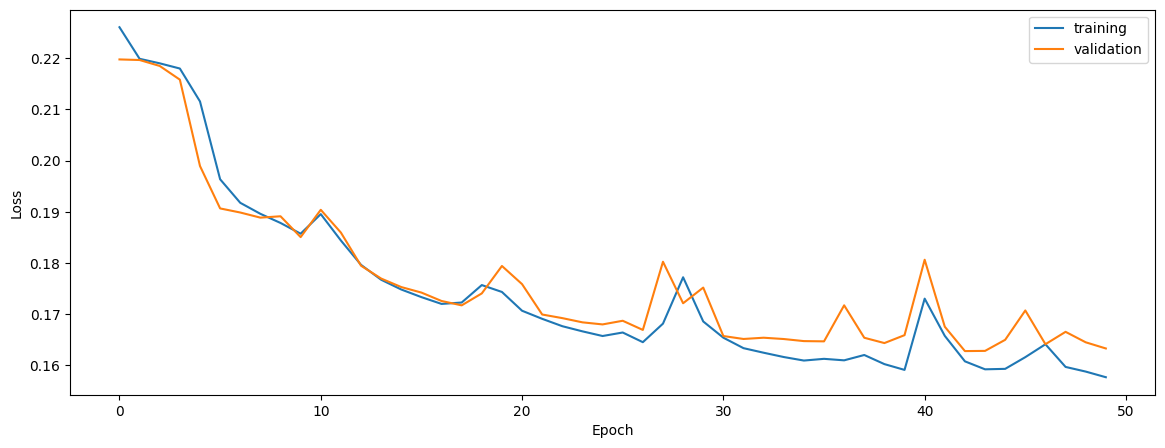

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6277611986761246
0.6039534521273833
0.5764317563263651


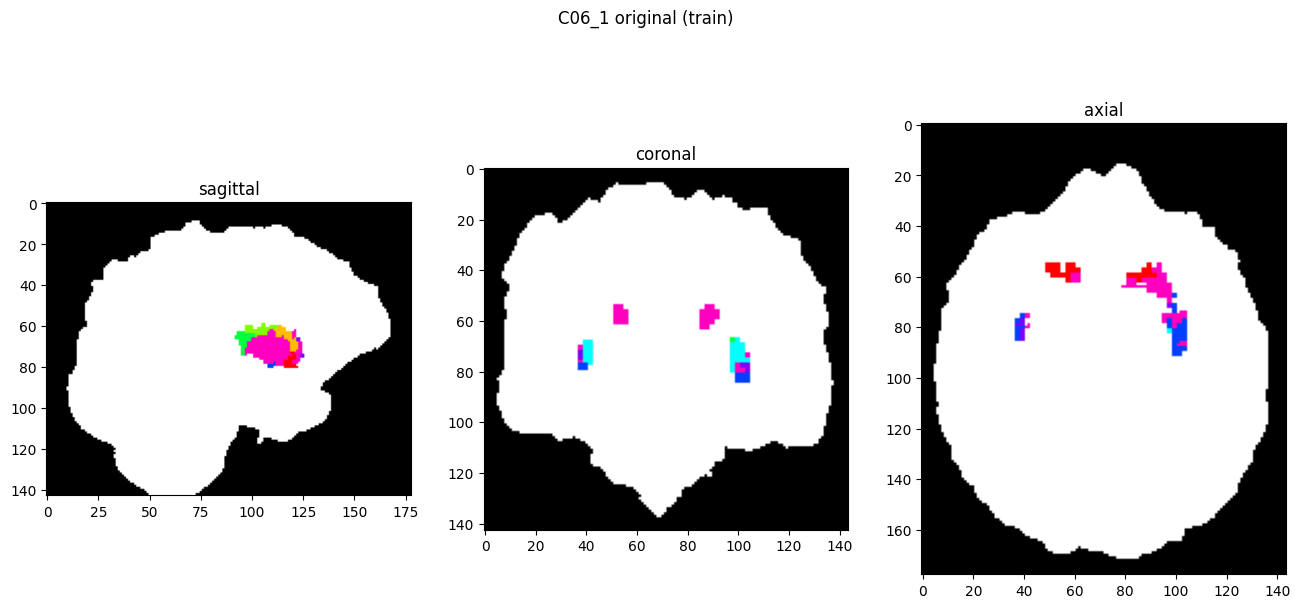

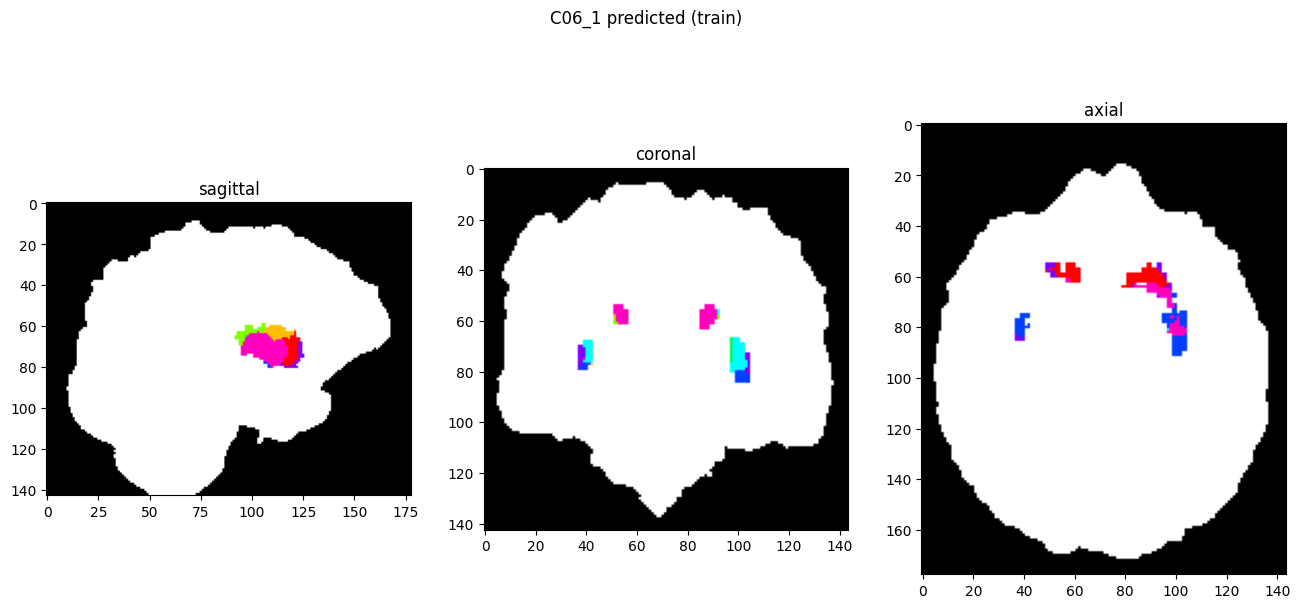

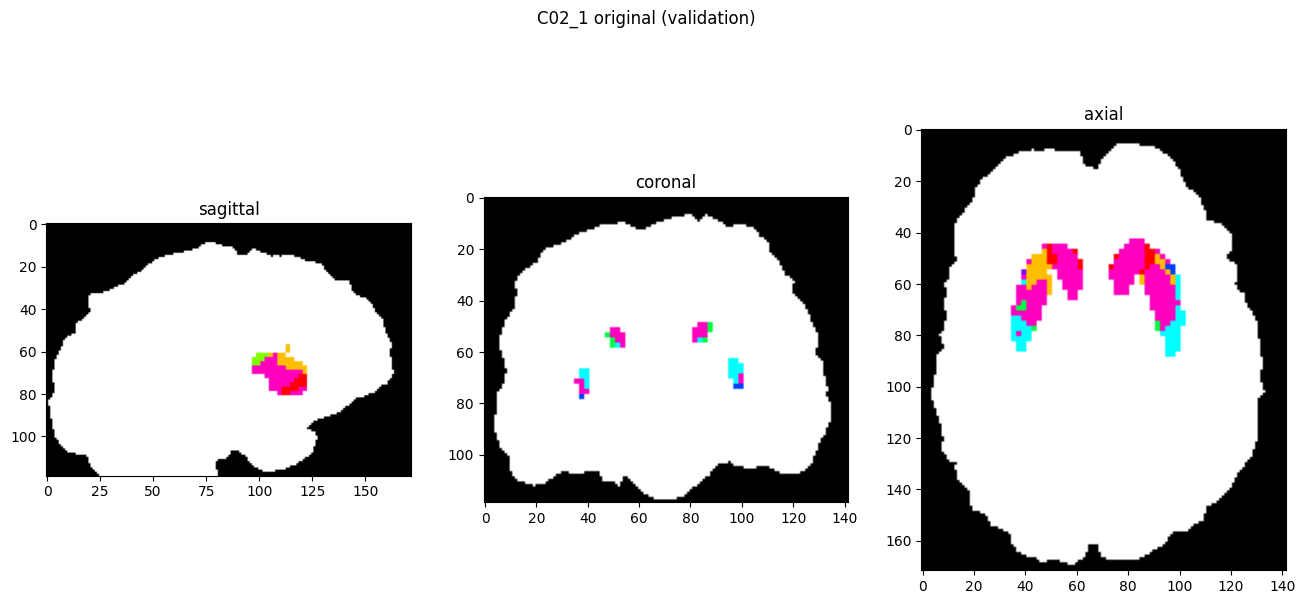

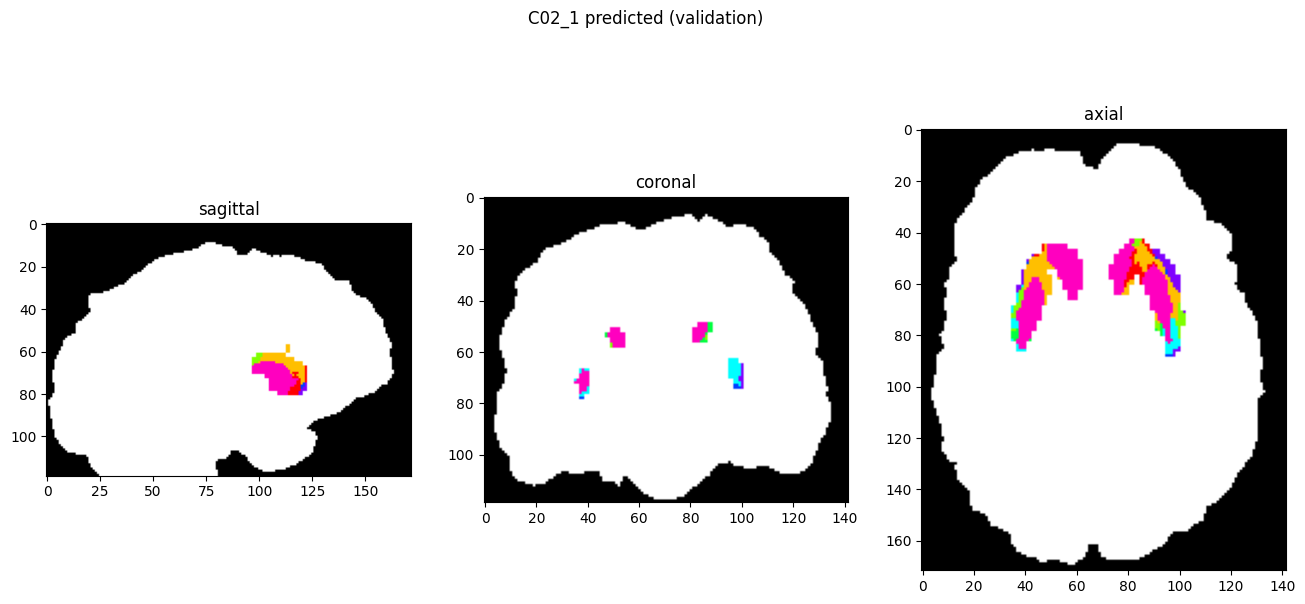

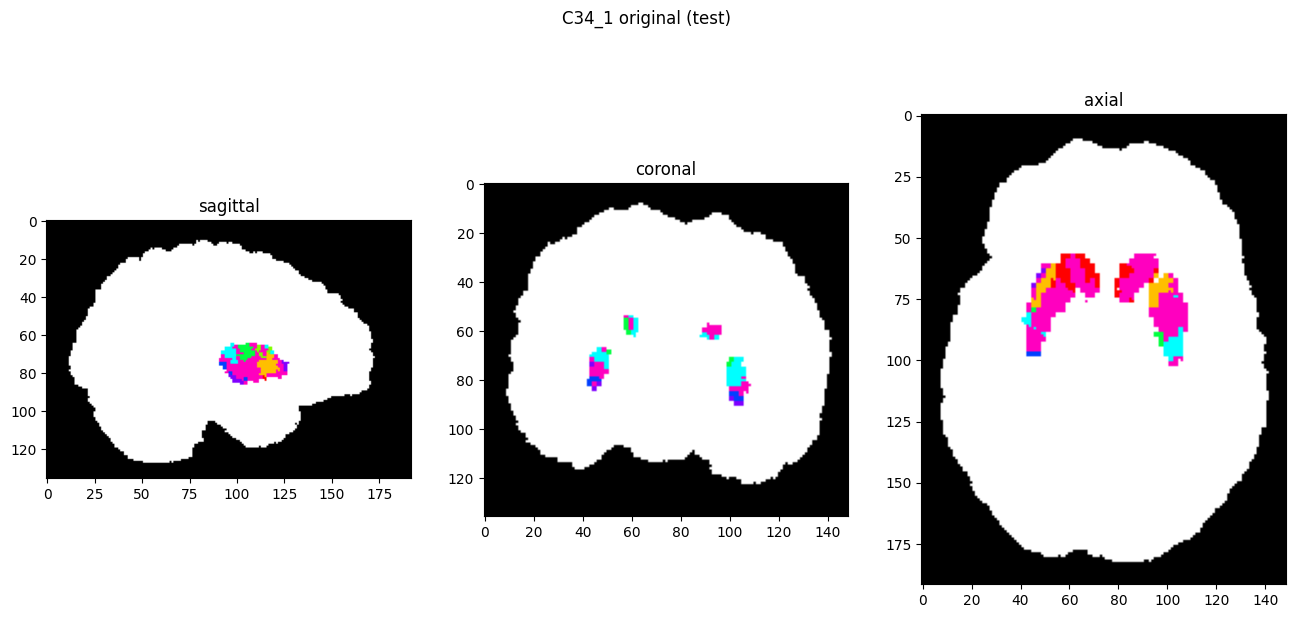

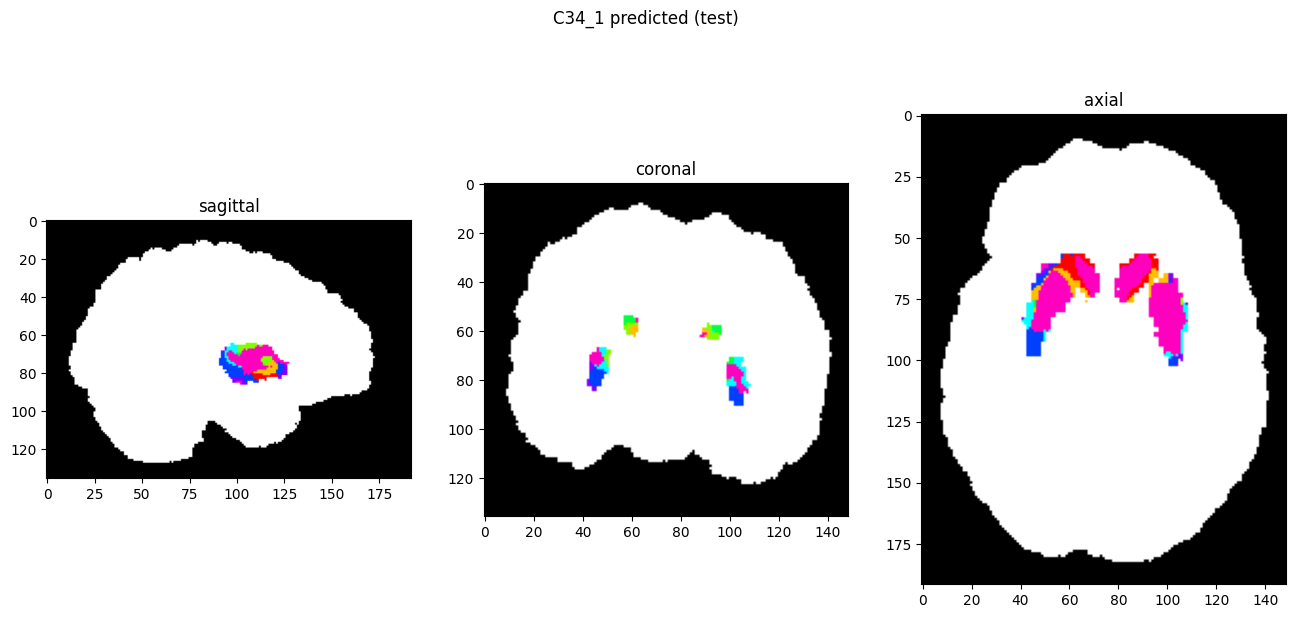

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)